<a href="https://colab.research.google.com/github/hsnaydos11/Tiny-Machine-Learning-Applying-Pruning-and-Quantization-Operations-in-CNN-Model/blob/main/Fruit_Detection_Pruning_Quantization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install memory-profiler

In [ ]:
pip install tensorflow-model-optimization


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 1.7 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import PIL
import tensorflow as tf
import shutil
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
import time
import psutil  # For memory usage
import numpy as np
from sklearn.metrics import accuracy_score
from memory_profiler import profile

from tensorflow.keras.applications import VGG16
import tensorflow_model_optimization as tfmot

In [ ]:
data_dir = '/content/drive/MyDrive/Fruit Dataset'

In [ ]:
import pathlib
data_dir = pathlib.Path(data_dir)

In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg')))
image_count

1709

In [ ]:
#sınıflardaki fotoğraflar etiketleme işlemi
fruit_images_dict = {
    'apple' : list(data_dir.glob('apple/*')),
    'orange' : list(data_dir.glob('orange/*')),
    'mandarin' : list(data_dir.glob('mandarin/*')),
    'banana' : list(data_dir.glob('banana/*'))
}
fruit_labels_dict = {
    'apple': 0,
    'orange' : 1,
    'mandarin' :2,
    'banana' :3
}

In [ ]:
#boyutlandırma işlemi

X, y = [], []

for fruit_name, images in fruit_images_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img, (180, 180))
        X.append(resized_img)
        y.append(fruit_labels_dict[fruit_name])

In [ ]:
X = np.array(X)
y = np.array(y)

In [ ]:
# Veri setini eğitim ve test kümelerine bölelim
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
#normalizasyon işlemi
X_train_scaled = X_train / 255
X_test_scaled = X_test / 255

In [ ]:
import tracemalloc
# memory usage kontrolü
tracemalloc.start()

num_classes = 5

model = Sequential([
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),

    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    layers.Dense(num_classes)
])


model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])



# eğitim zamanını ve hafıza kullanımını hesaplama
start_time = time.time()
start_memory = tracemalloc.get_traced_memory()

history =  model.fit(X_train_scaled, y_train, epochs=10, batch_size=16)
# Modelin summary'sini yazdırma
model.summary()

end_time = time.time()
end_memory = tracemalloc.get_traced_memory()
training_time = end_time - start_time
memory_usage = end_memory[0] - start_memory[0]

print(f"Training Time: {training_time} seconds")
print(f"Memory Usage: {memory_usage / (1024 ** 2)} MB")  # Convert to megabytes
tracemalloc.stop()

Epoch 1/10
89/89 [==============================] - 158s 2s/step - loss: 0.7688 - accuracy: 0.7734
Epoch 2/10
89/89 [==============================] - 155s 2s/step - loss: 0.4918 - accuracy: 0.8513
Epoch 3/10
89/89 [==============================] - 144s 2s/step - loss: 0.3467 - accuracy: 0.8902
Epoch 4/10
89/89 [==============================] - 146s 2s/step - loss: 0.3370 - accuracy: 0.8938
Epoch 5/10
89/89 [==============================] - 156s 2s/step - loss: 0.2959 - accuracy: 0.9001
Epoch 6/10
89/89 [==============================] - 148s 2s/step - loss: 0.2375 - accuracy: 0.9200
Epoch 7/10
89/89 [==============================] - 147s 2s/step - loss: 0.1918 - accuracy: 0.9370
Epoch 8/10
89/89 [==============================] - 147s 2s/step - loss: 0.1987 - accuracy: 0.9412
Epoch 9/10
89/89 [==============================] - 157s 2s/step - loss: 0.1683 - accuracy: 0.9448
Epoch 10/10
89/89 [==============================] - 148s 2s/step - loss: 0.1250 - accuracy: 0.9547
Model: "s

In [ ]:
model.evaluate(X_test_scaled,y_test)

12/12 [==============================] - 11s 891ms/step - loss: 0.2193 - accuracy: 0.9463


[0.21932779252529144, 0.9463276863098145]

In [ ]:
# Orijinal modelin kaydedilmesi
model.save('original_model.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Compute end step to finish pruning after 5 epochs.
batch_size = 16
epochs = 2  # Eğitimde kullanılacak toplam dönem sayısı
validation_split = 0.1  # Eğitim setinin %10'u doğrulama seti olarak ayrılacak.

# Eğitim setindeki görüntü sayısını hesaplayarak pruning işleminin ne zaman biteceğini belirleme
num_images = X_train_scaled.shape[0] * (1 - validation_split)
end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs

# Pruning için parametrelerin ayarlanması
pruning_params = {
    'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                             final_sparsity=0.90,
                                                             begin_step=0,
                                                             end_step=end_step)
}

# Pruning işleminin uygulanması
pruned_model = tfmot.sparsity.keras.prune_low_magnitude(model, **pruning_params)

# Pruned modelin derlenmesi
pruned_model.compile(optimizer='adam',
                     loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                     metrics=['accuracy'])

# Eğitim öncesi hafıza ve zaman ölçümü
tracemalloc.start()
start_time = time.time()
start_memory = tracemalloc.get_traced_memory()

# Pruned modelin eğitilmesi
callbacks = [
    tfmot.sparsity.keras.UpdatePruningStep(),
    tfmot.sparsity.keras.PruningSummaries(log_dir='/tmp/logs')
]

history = pruned_model.fit(X_train_scaled, y_train, epochs=epochs, batch_size=batch_size, callbacks=callbacks,
                           validation_split=validation_split)  # Eğitim ve doğrulama setlerini kullanarak modeli eğitme

# Pruned modelin özetini görüntüleme
pruned_model.summary()

# Eğitim sonrası hafıza ve zaman ölçümü
end_time = time.time()
end_memory = tracemalloc.get_traced_memory()
training_time = end_time - start_time
memory_usage = end_memory[0] - start_memory[0]

print(f"Pruned Training Time: {training_time} seconds")
print(f"Pruned Memory Usage: {memory_usage / (1024 ** 2)} MB")  # Megabayt cinsinden bellek kullanımını görüntüleme
tracemalloc.stop()


Epoch 1/2
80/80 [==============================] - 165s 2s/step - loss: 0.1597 - accuracy: 0.9543 - val_loss: 0.0749 - val_accuracy: 0.9789
Epoch 2/2
80/80 [==============================] - 143s 2s/step - loss: 0.4656 - accuracy: 0.8669 - val_loss: 0.8319 - val_accuracy: 0.7746
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_conv2d  (None, 180, 180, 32)      1762      
  (PruneLowMagnitude)                                            
                                                                 
 prune_low_magnitude_batch_  (None, 180, 180, 32)      129       
 normalization (PruneLowMag                                      
 nitude)                                                         
                                                                 
 prune_low_magnitude_max_po  (None, 90, 90, 32)        1         
 oling2d (PruneLowMagnitude             

In [ ]:
pruned_model.evaluate(X_test_scaled,y_test)

12/12 [==============================] - 10s 706ms/step - loss: 0.5864 - accuracy: 0.8898


[0.586379885673523, 0.8898305296897888]

In [ ]:
# Pruning wrapper'ını kaldırma
model_for_export = tfmot.sparsity.keras.strip_pruning(pruned_model)

# Modeli kaydetme
model_for_export.save('pruned_model.h5')


In [ ]:
# TensorFlow Lite Converter kullanarak kuantizasyon
converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Kuantize edilmiş modeli dönüştürme
tflite_model = converter.convert()

# TFLite modelini dosyaya kaydetme
with open('quantized_model.tflite', 'wb') as f:
    f.write(tflite_model)


In [ ]:
# TensorFlow Lite modelini yükleyin
interpreter = tf.lite.Interpreter(model_path='quantized_model.tflite')
interpreter.allocate_tensors()

# Modelin giriş ve çıkış detaylarını alın
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()


def evaluate_tflite_model(interpreter, test_images, test_labels):
    input_index = input_details[0]['index']
    output_index = output_details[0]['index']

    prediction_labels = []

    for i in range(len(test_images)):
        input_data = np.expand_dims(test_images[i], axis=0).astype(np.float32)
        interpreter.set_tensor(input_index, input_data)
        interpreter.invoke()
        output = interpreter.get_tensor(output_index)
        predicted_label = np.argmax(output[0])
        prediction_labels.append(predicted_label)

    prediction_labels = np.array(prediction_labels)
    accuracy = np.sum(prediction_labels == test_labels) / len(test_labels)
    return accuracy

accuracy = evaluate_tflite_model(interpreter, X_test_scaled, y_test)
print(f"Quantized Model Accuracy: {accuracy * 100:.2f}%")

Quantized Model Accuracy: 67.51%


In [ ]:
# Orijinal modelin boyutunun alınması
original_model_size = os.path.getsize('original_model.h5') / (1024 ** 2)  # MB cinsinden

# Pruned modelin boyutunun alınması
pruned_model_size = os.path.getsize('pruned_model.h5') / (1024 ** 2)  # MB cinsinden

# Kuantize edilmiş modelin boyutunu hesaplama
quantized_model_size = os.path.getsize('quantized_model.tflite') / (1024 ** 2)


print(f"Original Model Size: {original_model_size:.2f} MB")
print(f"Pruned Model Size: {pruned_model_size:.2f} MB")
print(f"Quantized Model Size: {quantized_model_size:.2f} MB")

Original Model Size: 183.07 MB
Pruned Model Size: 61.05 MB
Quantized Model Size: 15.26 MB


KAMERA BÖLÜMÜ

In [ ]:
def predict_fruit(frame):
    # Modelinize göre görüntüyü önişleme yapabilir ve tahminlerde bulunabilirsiniz.
    # Örnek olarak, resmi yeniden boyutlandırma ve normalleştirme işlemleri yapalım.
    resized_frame = cv2.resize(frame, (180, 180))
    normalized_frame = resized_frame / 255.0  # Örnek normalizasyon

    # Tahmin
    predictions = model.predict(np.expand_dims(normalized_frame, axis=0))

    # Sınıf indeksi
    predicted_class_index = np.argmax(predictions)

    # Sınıf etiketi
    class_labels = {0: 'Apple', 1: 'Orange', 2: 'Mandarin'}
    predicted_class_label = class_labels[predicted_class_index]

    # Görüntü üzerine sonuçları çizme
    cv2.putText(frame, f'Predicted Fruit: {predicted_class_label}', (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)

    return frame

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 308ms/step


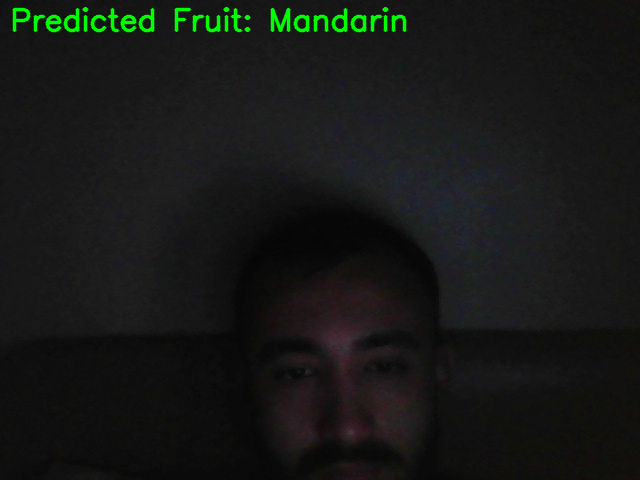

Detection Speed: 0.04 frames per second
1/1 [==============================] - 0s 23ms/step


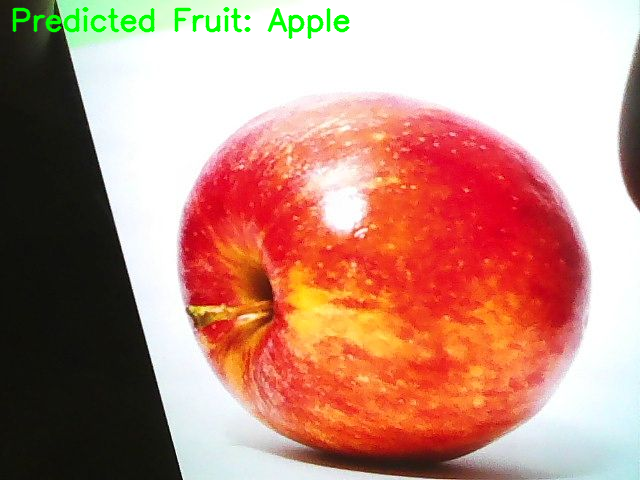

Detection Speed: 0.56 frames per second
1/1 [==============================] - 0s 25ms/step


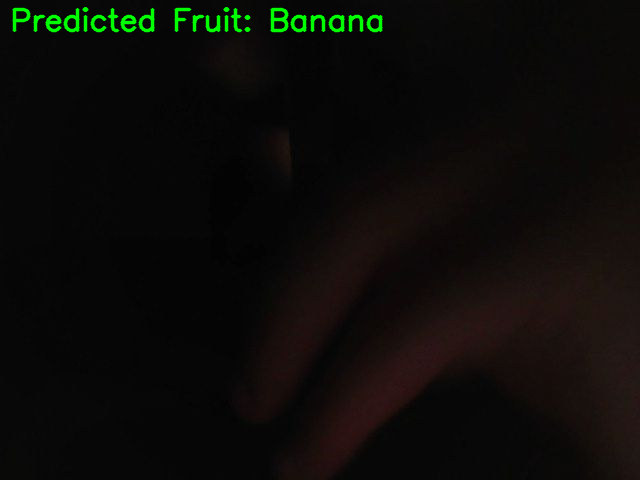

Detection Speed: 1.31 frames per second
1/1 [==============================] - 0s 23ms/step


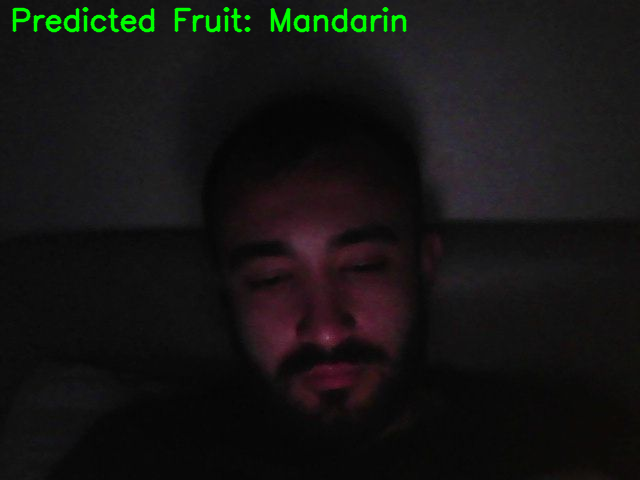

Detection Speed: 0.71 frames per second
1/1 [==============================] - 0s 25ms/step


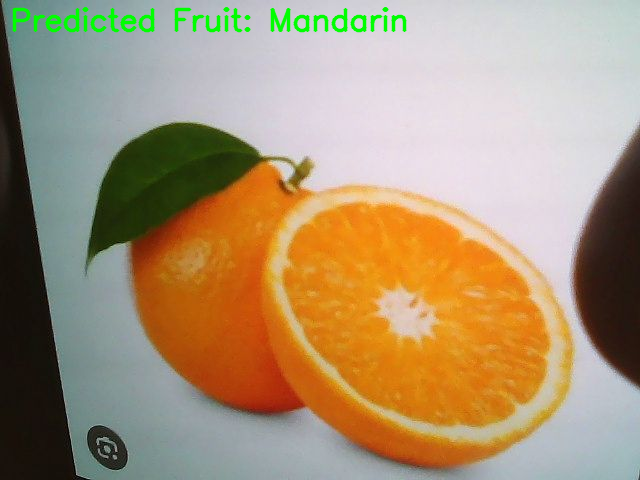

Detection Speed: 1.06 frames per second
1/1 [==============================] - 0s 22ms/step


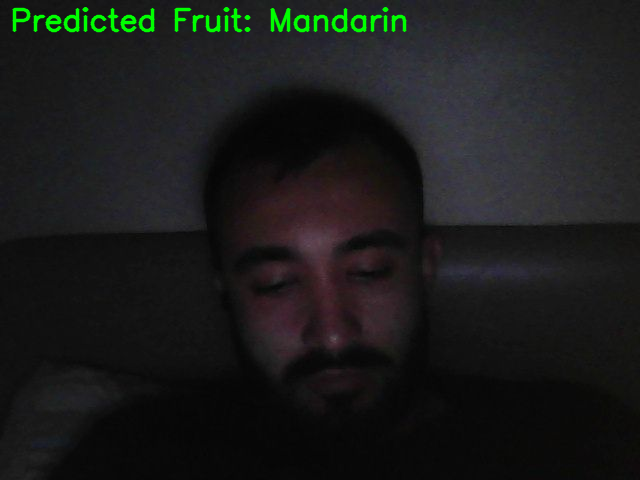

Detection Speed: 1.39 frames per second
1/1 [==============================] - 0s 24ms/step


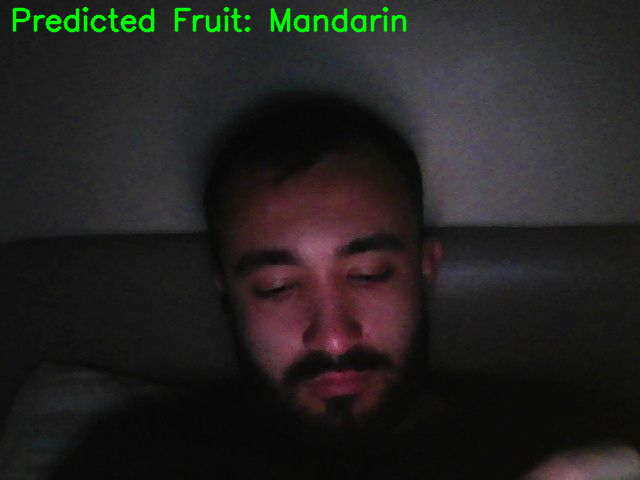

Detection Speed: 1.33 frames per second
1/1 [==============================] - 0s 33ms/step


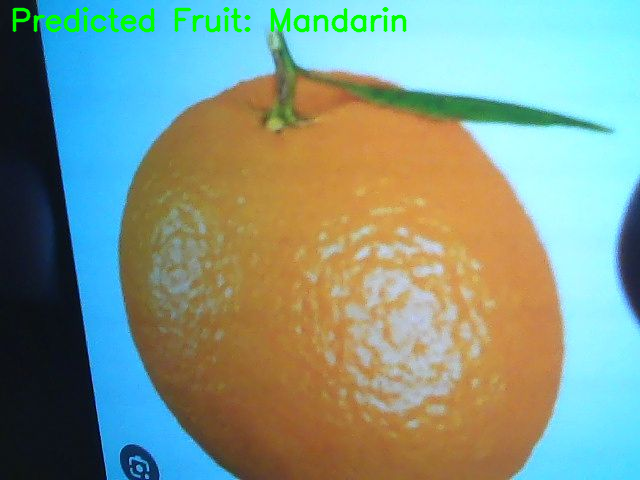

Detection Speed: 1.05 frames per second
1/1 [==============================] - 0s 26ms/step


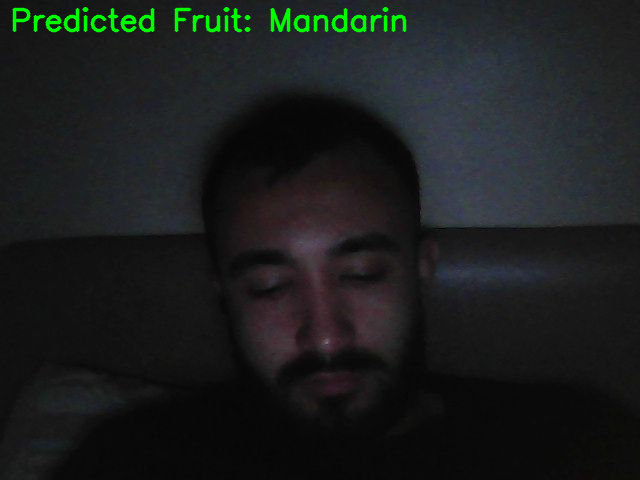

Detection Speed: 1.20 frames per second
1/1 [==============================] - 0s 31ms/step


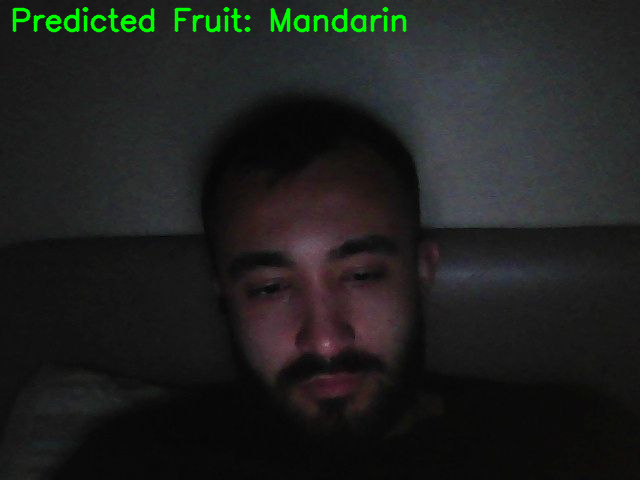

Detection Speed: 0.90 frames per second
1/1 [==============================] - 0s 23ms/step


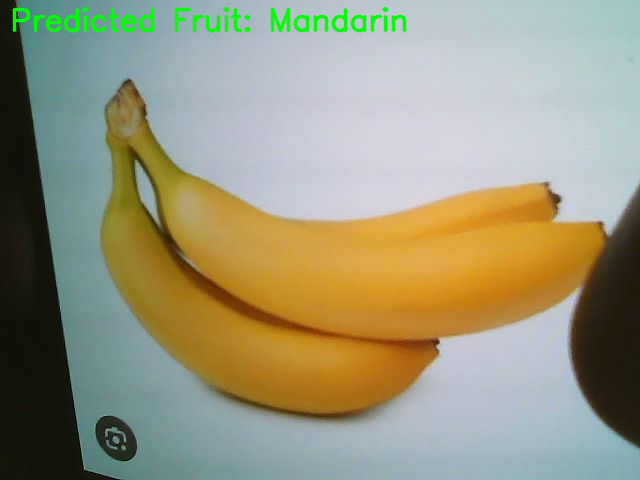

Detection Speed: 1.04 frames per second
1/1 [==============================] - 0s 24ms/step


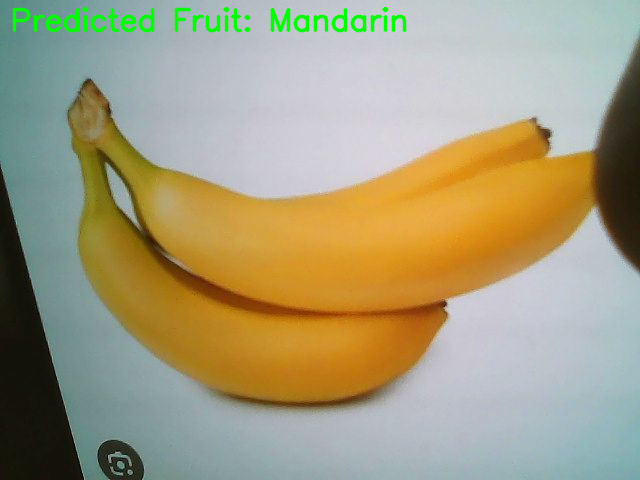

Detection Speed: 0.82 frames per second


KeyboardInterrupt: 

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode
import base64

# JavaScript ile video akışını açma işlemi
def video_stream():
    js = Javascript('''
        var video;
        var div = null;
        var stream;
        var captureCanvas;
        var imgElement;
        var labelElement;

        var pendingResolve = null;
        var shutdown = false;

        function removeDom() {
            stream.getVideoTracks()[0].stop();
            video.remove();
            div.remove();
            video = null;
            div = null;
            stream = null;
            imgElement = null;
            captureCanvas = null;
            labelElement = null;
        }

        function onAnimationFrame() {
            if (!shutdown) {
                window.requestAnimationFrame(onAnimationFrame);
            }
            if (pendingResolve) {
                var result = "";
                if (!shutdown) {
                    captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
                    result = captureCanvas.toDataURL('image/jpeg', 0.8);
                }
                var lp = pendingResolve;
                pendingResolve = null;
                lp(result);
            }
        }

        async function createDom() {
            if (div !== null) {
                return stream;
            }

            div = document.createElement('div');
            div.style.border = '2px solid black';
            div.style.padding = '3px';
            div.style.width = '100%';
            div.style.maxWidth = '600px';
            document.body.appendChild(div);

            const modelOut = document.createElement('div');
            modelOut.innerHTML = "<span>Status:</span>";
            labelElement = document.createElement('span');
            labelElement.innerText = 'No data';
            labelElement.style.fontWeight = 'bold';
            modelOut.appendChild(labelElement);
            div.appendChild(modelOut);

            video = document.createElement('video');
            video.style.display = 'block';
            video.width = div.clientWidth - 6;
            video.setAttribute('playsinline', '');
            video.onclick = () => { shutdown = true; };
            stream = await navigator.mediaDevices.getUserMedia({ video: { facingMode: "environment" } });
            div.appendChild(video);

            imgElement = document.createElement('img');
            imgElement.style.position = 'absolute';
            imgElement.style.zIndex = 1;
            imgElement.onclick = () => { shutdown = true; };
            div.appendChild(imgElement);

            const instruction = document.createElement('div');
            instruction.innerHTML = '<span style="color: red; font-weight: bold;">' +
                'When finished, click here or on the video to stop this demo</span>';
            div.appendChild(instruction);
            instruction.onclick = () => { shutdown = true; };

            video.srcObject = stream;
            await video.play();

            captureCanvas = document.createElement('canvas');
            captureCanvas.width = 640;
            captureCanvas.height = 480;
            window.requestAnimationFrame(onAnimationFrame);

            return stream;
        }

        async function stream_frame(label, imgData) {
            if (shutdown) {
                removeDom();
                shutdown = false;
                return '';
            }

            var preCreate = Date.now();
            stream = await createDom();

            var preShow = Date.now();
            if (label !== "") {
                labelElement.innerHTML = label;
            }

            if (imgData !== "") {
                var videoRect = video.getClientRects()[0];
                imgElement.style.top = videoRect.top + "px";
                imgElement.style.left = videoRect.left + "px";
                imgElement.style.width = videoRect.width + "px";
                imgElement.style.height = videoRect.height + "px";
                imgElement.src = imgData;
            }

            var preCapture = Date.now();
            var result = await new Promise(function (resolve, reject) {
                pendingResolve = resolve;
            });
            shutdown = false;

            return {
                'create': preShow - preCreate,
                'show': preCapture - preShow,
                'capture': Date.now() - preCapture,
                'img': result
            };
        }
        ''')

    display(js)

def video_frame(label, bbox):
    data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
    return data

# video_stream fonksiyonunu çağırarak video akışını başlatın
video_stream()

# etiket için video
label_html = 'Capturing...'
# başlangıçta bounding box'ı boş olarak başlat
bbox = ''
count = 0

# Tanınan meyveleri tanımla
class_labels = {0: 'Apple', 1: 'Orange', 2: 'Mandarin', 3: 'Banana'}

# Kamera görüntüsünü al ve göster
while True:
    # Her döngünün başında toplam meyve sayısını sıfırla
    total_fruit_count = 0


    # Başlangıç zamanını kaydet
    start_time = time.time()

    # JavaScript tarafından dönen veriyi işleme
    js_result = video_frame(label_html, bbox)['img']

    # Base64 kodlu görüntü verisini çözümleme
    image_data = base64.b64decode(js_result.split(',')[1])

    # Görüntüyü OpenCV ile açma
    frame = cv2.imdecode(np.frombuffer(image_data, np.uint8), -1)

    # Modelinizi kullanarak meyve tanıma işlemi
    # Bu kısmı modelinize ve veri ön işleme işlemlerinize göre özelleştirebilirsiniz
    resized_frame = cv2.resize(frame, (180, 180))
    normalized_frame = resized_frame / 255.0
    predictions = model.predict(np.expand_dims(normalized_frame, axis=0))
    predicted_class_index = np.argmax(predictions)

    # Tanınan meyveyi etiketle, tanımlı meyveler dışındakiler için "Tanımsız" etiketi ver
    predicted_class_label = class_labels.get(predicted_class_index, 'Tanımsız')

    # Görüntü üzerine sonuçları çizme
    cv2.putText(frame, f'Predicted Fruit: {predicted_class_label}', (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)

    # Görüntüyü göster
    cv2_imshow(frame)

    # Bitiş zamanını kaydet
    end_time = time.time()

    # Detection speed'i hesapla ve yazdır
    detection_speed = 1 / (end_time - start_time)
    print(f"Detection Speed: {detection_speed:.2f} frames per second")

      # 1 saniye beklet
    time.sleep(6)

    # Çıkış için 'q' tuşuna basılmasını bekleyin
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break